#  Обнаружение объектов

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
* https://pyimagesearch.com/2021/11/01/training-an-object-detector-from-scratch-in-pytorch/
* https://pyimagesearch.com/2021/08/02/pytorch-object-detection-with-pre-trained-networks/

## Задачи для совместного разбора

1. Рассмотрите простейшую архитектуру для решения задачи object detection и процесс настройки модели.

In [1]:
import torch as th
import torch.nn as nn

In [2]:
imgs = th.rand(size=(16, 3, 100, 100))
bboxes = th.rand(size=(16, 4))
labels = th.randint(0, 2, size=(16, ))

In [3]:
labels

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1])

In [4]:
class Detector(nn.Module):
  def __init__(self):
    super().__init__()

    self.backbone = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=2),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    n_features = 64 * 49 * 49
    self.classifier = nn.Sequential(
        nn.Linear(n_features, 64),
        nn.ReLU(),
        nn.Linear(64, 2)
    )

    self.regressor = nn.Sequential(
        nn.Linear(n_features, 64),
        nn.ReLU(),
        nn.Linear(64, 4)
    )

  def forward(self, X):
    features = self.backbone(X).flatten(start_dim=1)
    return self.classifier(features), self.regressor(features)

In [5]:
model = Detector()
label_pred, bbox_pred = model(imgs)

In [6]:
import torch.nn.functional as F

In [7]:
# F.cross_entropy(label_pred, labels)
F.mse_loss(bbox_pred, bboxes)

tensor(0.3717, grad_fn=<MseLossBackward0>)

In [8]:
bbox_pred.shape

torch.Size([16, 4])

In [9]:
bboxes.shape

torch.Size([16, 4])

## Задачи для самостоятельного решения

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# !unzip /content/drive/MyDrive/Учеба/DL/06_cv/animals.zip -d /content/drive/MyDrive/Учеба/DL/06_cv

In [2]:
import torch
import torch.nn as nn
from bs4 import BeautifulSoup
from torch.utils.data import Dataset
from torchvision.transforms import  v2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import os
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.models as models
from torchvision.models import ResNet50_Weights
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import warnings
warnings.filterwarnings("ignore")

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

<p class="task" id="1"></p>

1\. Напишите функцию `parse_xml`, которая читает xml-файл с разметкой изображения из архива `animals.zip` и возвращает словарь, содержащий три ключа:
```
{
        "raw": # словарь с ключами xmin, ymin, xmax, ymax
        "scaled": # словарь с ключами xmin, ymin, xmax, ymax
        "obj_name": # строка
}
```
В этом словаре `row` - абсолютные значения координат вершин bounding box, а `scaled` - относительные (нормированные на ширину и высоту изображения). Примените функцию к файлу `cat.0.xml` и выведите результат на экран.


- [ ] Проверено на семинаре

In [3]:
def parse_xml(path):
  with open(path, 'r') as f:
    data = f.read()
  Bs_data = BeautifulSoup(data, "xml")

  obj_name = Bs_data.find('name').text
  w = int(Bs_data.find('width').text)
  h = int(Bs_data.find('height').text)

  coor_names = ['xmin', 'ymin', 'xmax', 'ymax']
  raw_coor = {name: float(Bs_data.find(name).text) for name in coor_names}

  scaled_coor = {
      'xmin': raw_coor['xmin']/w,
      'ymin': raw_coor['ymin']/h,
      'xmax': raw_coor['xmax']/w,
      'ymax': raw_coor['ymax']/h
      }

  d = {
      "raw": raw_coor,
      "scaled": scaled_coor,
      "obj_name": obj_name
      }

  return d

In [6]:
path = "/content/drive/MyDrive/Учеба/DL/06_cv/Asirra: cat vs dogs/cat.0.xml"
parse_xml(path)

{'raw': {'xmin': 126.0, 'ymin': 83.0, 'xmax': 354.0, 'ymax': 243.0},
 'scaled': {'xmin': 0.252,
  'ymin': 0.22192513368983957,
  'xmax': 0.708,
  'ymax': 0.6497326203208557},
 'obj_name': 'cat'}

<p class="task" id="2"></p>

2\. Опишите датасет `AnimalDetectionDataset` на основе архива `animals.zip`. Реализуйте `__getitem__` таким образом, чтобы он возвращал три элемента: тензор с изображением, словарь с координатами bounding box и метку объекта. Предусмотрите возможность передавать извне при создании датасета набор преобразований для изображений, преобразование для метки объекта (для кодирования) и флаг, показывающий, нужно ли возвращать исходные или нормированные координаты bounding box.

- [ ] Проверено на семинаре

In [4]:
from torch.utils.data import Dataset

get_file_name = np.vectorize(lambda root, x: '/'.join([root, x[:-4]]))

class AnimalDetectionDataset(Dataset):
    def __init__(self, root, transforms=None, target_transform=None, return_scaled=True):
        self.root = root
        self.transforms = transforms
        self.target_transform = target_transform
        self.return_scaled = return_scaled

        files = os.listdir(self.root)
        self.file_names = np.unique(get_file_name(root, files))

    def __getitem__(self, index):
        name = self.file_names[index]
        annot = parse_xml('.'.join([name, 'xml']))
        img = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])(Image.open('.'.join([name, 'jpg'])))

        if self.transforms:
          img = self.transforms(img)

        if self.return_scaled:
          bbox = annot['scaled']
        else:
          bbox = annot['raw']

        if self.target_transform:
          label = self.target_transform.transform([annot['obj_name']])
        else:
          label = annot['obj_name']

        return img, bbox, label

    def __len__(self):
        return len(self.file_names)

<p class="task" id="3"></p>

3\. Создайте объект класса `AnimalDetectionDataset` без применения преобразований и со значением `return_scaled=False`. Напишите функцию `show_image_with_bounding_box` для визуализации изображения с добавлением на него bounding box и подписи объекта. Продемонстрируйте работу функцию на изображении собаки и кошки.

- [ ] Проверено на семинаре

In [8]:
root = "/content/drive/MyDrive/Учеба/DL/06_cv/Asirra: cat vs dogs"
dset = AnimalDetectionDataset(root, return_scaled=False)
dset[0]

(Image([[[0.7961, 0.7961, 0.8000,  ..., 0.9412, 0.9373, 0.9333],
         [0.7961, 0.7961, 0.8000,  ..., 0.9451, 0.9412, 0.9333],
         [0.7961, 0.7961, 0.8000,  ..., 0.9451, 0.9412, 0.9373],
         ...,
         [0.6000, 0.6000, 0.6000,  ..., 0.0078, 0.0078, 0.0078],
         [0.5961, 0.5961, 0.5961,  ..., 0.0078, 0.0078, 0.0078],
         [0.5922, 0.5922, 0.5922,  ..., 0.0039, 0.0039, 0.0039]],
 
        [[0.6431, 0.6431, 0.6471,  ..., 0.7882, 0.7843, 0.7804],
         [0.6431, 0.6431, 0.6471,  ..., 0.7922, 0.7882, 0.7804],
         [0.6431, 0.6431, 0.6471,  ..., 0.7922, 0.7882, 0.7843],
         ...,
         [0.4784, 0.4784, 0.4784,  ..., 0.0078, 0.0078, 0.0078],
         [0.4745, 0.4745, 0.4745,  ..., 0.0078, 0.0078, 0.0078],
         [0.4706, 0.4706, 0.4706,  ..., 0.0039, 0.0039, 0.0039]],
 
        [[0.3412, 0.3412, 0.3451,  ..., 0.4784, 0.4745, 0.4706],
         [0.3412, 0.3412, 0.3451,  ..., 0.4824, 0.4784, 0.4706],
         [0.3412, 0.3412, 0.3451,  ..., 0.4824, 0.4784, 

In [5]:
def show_image_with_bounding_box(dset_instance, pred=None, target_transform=None, scaled=False, mean=None, std=None): # pred=(box_pred, label_pred)
  img = dset_instance[0]
  if mean is not None and std is not None:
    img = img*std.reshape(-1,1,1) + mean.reshape(-1,1,1)

  xmin, ymin, xmax, ymax = dset_instance[1].values()
  if scaled:
    xmin, ymin, xmax, ymax = xmin*img.shape[-1], ymin*img.shape[-2], xmax*img.shape[-1], ymax*img.shape[-2]

  label = dset_instance[2]
  if not isinstance(label, str):
    label = target_transform.inverse_transform(label)[0]

  width = xmax - xmin
  height = ymax - ymin
  rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='tab:green', facecolor='none', label='True')

  fig, ax = plt.subplots(1)
  ax.imshow(img.permute(1,2,0))
  ax.add_patch(rect)
  plt.text((xmax+xmin)/2-10, ymin-10, label, color='tab:green', fontsize=14, bbox=dict(facecolor='white', alpha=0.7))

  if pred:
    label = target_transform.inverse_transform([pred[1]])[0]
    xmin, ymin, xmax, ymax = pred[0]
    if scaled:
      xmin, ymin, xmax, ymax = pred[0]*torch.tensor([img.shape[-1], img.shape[-2], img.shape[-1], img.shape[-2]])
    width = xmax - xmin
    height = ymax - ymin
    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none', label='Predicted')
    ax.add_patch(rect)
    plt.text((xmax+xmin)/2-10, ymin-10, label, color='r', fontsize=14, bbox=dict(facecolor='white', alpha=0.7))
  plt.legend()
  plt.show()

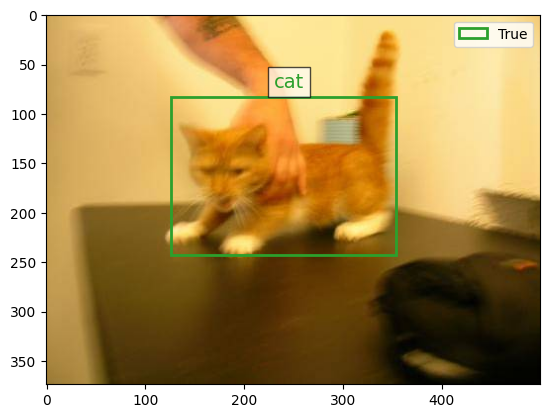

In [130]:
show_image_with_bounding_box(dset[0])

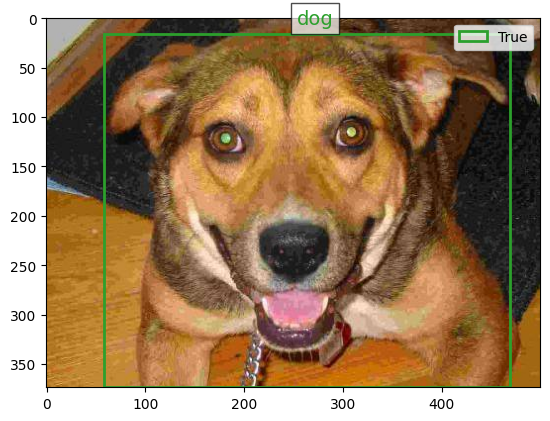

In [131]:
show_image_with_bounding_box(dset[-1])

<p class="task" id="4"></p>

4\. Напишите модель для решения задачи выделения объектов. Реализуйте двухголовую сеть, одна голова которой предсказывает метку объекта (задача классификации), а вторая голова предсказывает 4 координаты вершин bounding box (задача регрессии). В качестве backbone используйте модель resnet50 из пакета `torchvision`.

- [ ] Проверено на семинаре

In [50]:
class Detector(nn.Module):
  def __init__(self, num_classes=2):
    super(Detector, self).__init__()
    self.backbone = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])
    for param in self.backbone.parameters():
        param.requires_grad = False

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(2048, num_classes)
    )

    self.regressor = nn.Sequential(
        nn.Flatten(),
        nn.Linear(2048, 4)
    )

  def forward(self, input):
    out = self.backbone(input)
    cl_out = self.classifier(out)
    reg_out = self.regressor(out)
    return cl_out, reg_out

<p class="task" id="5"></p>

5\. Разбейте набор данных на обучающее и валидационное множество. Обучите модель, описанную в задаче 4. При создании датасета не забудьте указать преобразования, соответствующие модели ResNet.

Используйте сумму MSELoss (для расчета ошибки на задаче регрессии) и CrossEntropyLoss (для расчета ошибки на задачи классификации) для настройки весов модели. Для ускорения процесса обучения слои backbone можно заморозить. Во время обучения выводите на экран значения функции потерь на обучающем и валидационном множестве. Используя обученную модель, получите предсказания для изображения кошки и собаки и отрисуйте их. Выполните процедуру, обратную нормализации, чтобы корректно отобразить фотографии.

- [ ] Проверено на семинаре

In [31]:
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder

model = Detector().to(device)
cl_criterion = nn.CrossEntropyLoss()
reg_criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
le = LabelEncoder().fit(['cat', 'dog'])

root = "/content/drive/MyDrive/Учеба/DL/06_cv/Asirra: cat vs dogs"
dataset = AnimalDetectionDataset(root, transforms=ResNet50_Weights.IMAGENET1K_V2.transforms(), target_transform=le)

batch_size = 32
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_epochs = 10
for epoch in range(num_epochs):
  model.train()
  train_cl_loss = 0
  train_reg_loss = 0
  for imgs, coors, labels in train_loader:
    imgs, coors, labels = imgs.to(device), torch.stack(list(coors.values())).T.float().to(device), labels.to(device)
    cl_out, reg_out = model(imgs)
    cl_loss = cl_criterion(cl_out, labels.flatten().long())
    reg_loss = reg_criterion(reg_out, coors)

    train_cl_loss += cl_loss.item()
    train_reg_loss += reg_loss.item()

    optimizer.zero_grad()
    cl_loss.backward()
    reg_loss.backward()
    optimizer.step()

  print(f"-----epoch {epoch+1}-----")
  print("train: \n",
        f"classification loss: {round(train_cl_loss/imgs.shape[0], 3)}\n",
        f"regression loss: {round(train_reg_loss/imgs.shape[0], 3)} ")

  model.eval()
  with torch.no_grad():
    test_cl_loss = 0
    test_reg_loss = 0
    for imgs, coors, labels in test_loader:
      imgs, coors, labels = imgs.to(device), torch.stack(list(coors.values())).T.float().to(device), labels.to(device)
      cl_out, reg_out = model(imgs)
      cl_loss = cl_criterion(cl_out, labels.flatten().long())
      reg_loss = reg_criterion(reg_out, coors)

      test_cl_loss += cl_loss.item()
      test_reg_loss += reg_loss.item()

    print("test: \n",
          f"classification loss: {round(test_cl_loss/imgs.shape[0], 3)}\n",
          f"regression loss: {round(test_reg_loss/imgs.shape[0], 3)}\n")

-----epoch 1-----
train: 
 classification loss: 0.675
 regression loss: 0.159 
test: 
 classification loss: 0.057
 regression loss: 0.011

-----epoch 2-----
train: 
 classification loss: 0.281
 regression loss: 0.065 
test: 
 classification loss: 0.039
 regression loss: 0.009

-----epoch 3-----
train: 
 classification loss: 0.187
 regression loss: 0.037 
test: 
 classification loss: 0.034
 regression loss: 0.008

-----epoch 4-----
train: 
 classification loss: 0.146
 regression loss: 0.034 
test: 
 classification loss: 0.031
 regression loss: 0.007

-----epoch 5-----
train: 
 classification loss: 0.121
 regression loss: 0.028 
test: 
 classification loss: 0.027
 regression loss: 0.006

-----epoch 6-----
train: 
 classification loss: 0.127
 regression loss: 0.024 
test: 
 classification loss: 0.03
 regression loss: 0.007

-----epoch 7-----
train: 
 classification loss: 0.104
 regression loss: 0.021 
test: 
 classification loss: 0.024
 regression loss: 0.006

-----epoch 8-----
train: 
 c

In [117]:
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

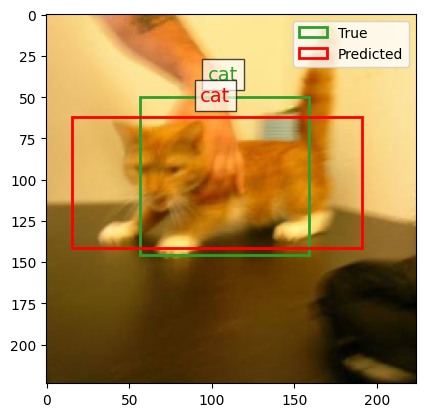

In [135]:
# cat
model.eval()
cl_out, reg_out = model(dataset[0][0].unsqueeze(0).to(device))

show_image_with_bounding_box(dataset[0], pred=(reg_out.squeeze(0).detach().cpu(), cl_out.argmax().item()), target_transform=le, scaled=True, mean=mean, std=std)

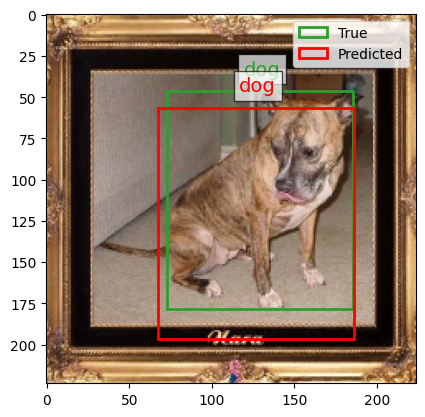

In [136]:
# dog
model.eval()
cl_out, reg_out = model(dataset[-2][0].unsqueeze(0).to(device))

show_image_with_bounding_box(dataset[-2], pred=(reg_out.squeeze(0).detach().cpu(), cl_out.argmax().item()), target_transform=le, scaled=True, mean=mean, std=std)

<p class="task" id="6"></p>

6\. Найдите в сети несколько изображений котов и собак. Используя любой инструмент для разметки (например, [CVAT](https://www.cvat.ai/)), выделите котов и собак на изображениях. Вставьте скриншот экспортированного файла с разметкой. Используя полученные изображения, визуализируйте разметку и bounding boxes, полученные при помощи модели.

- [ ] Проверено на семинаре

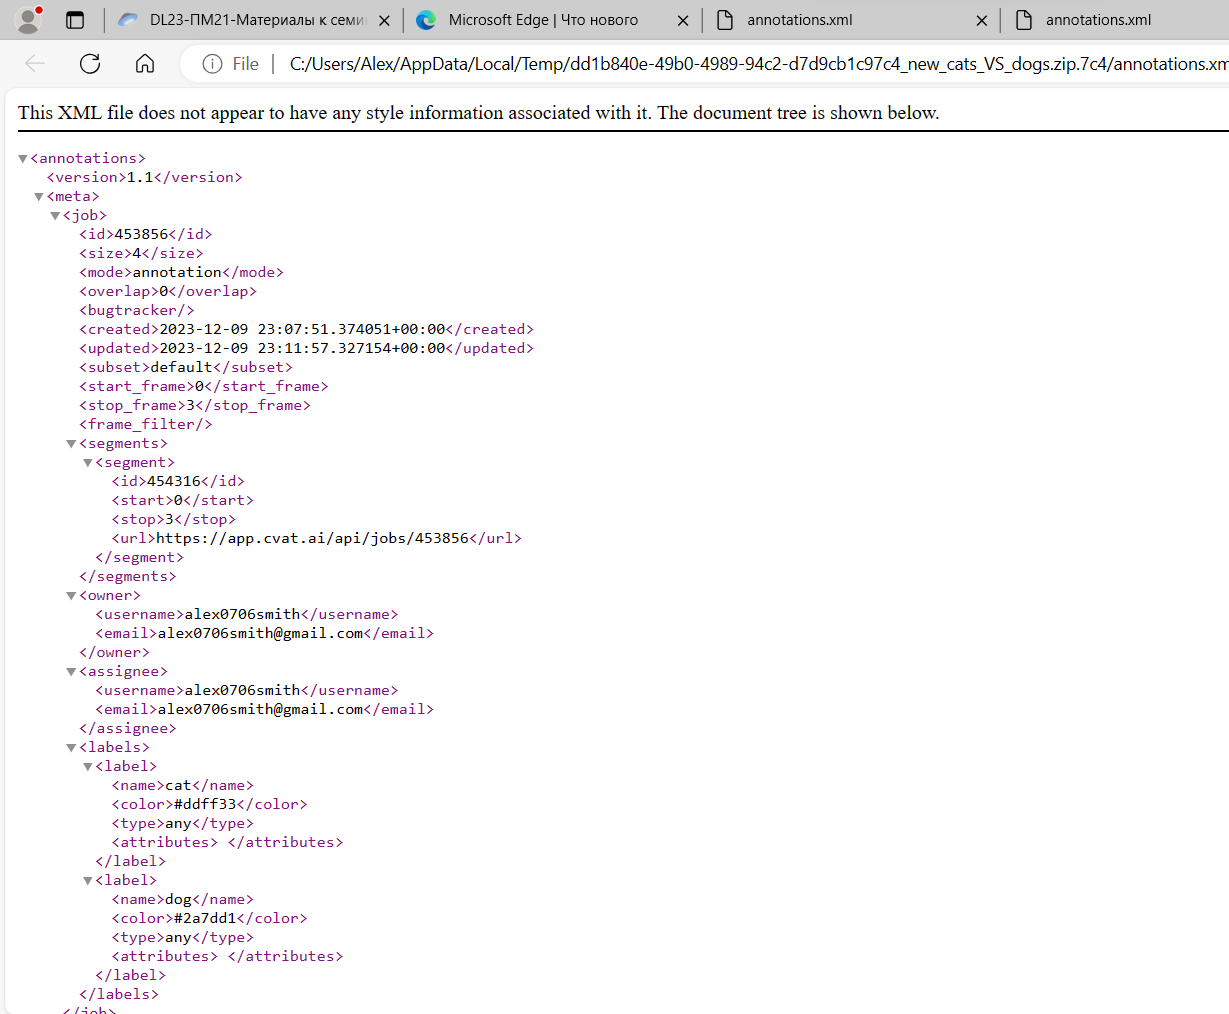

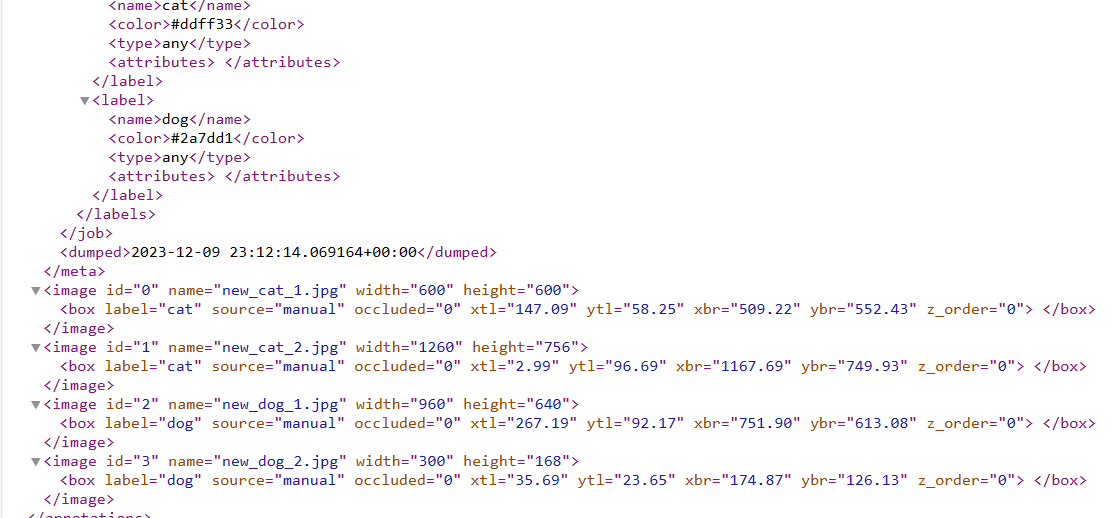

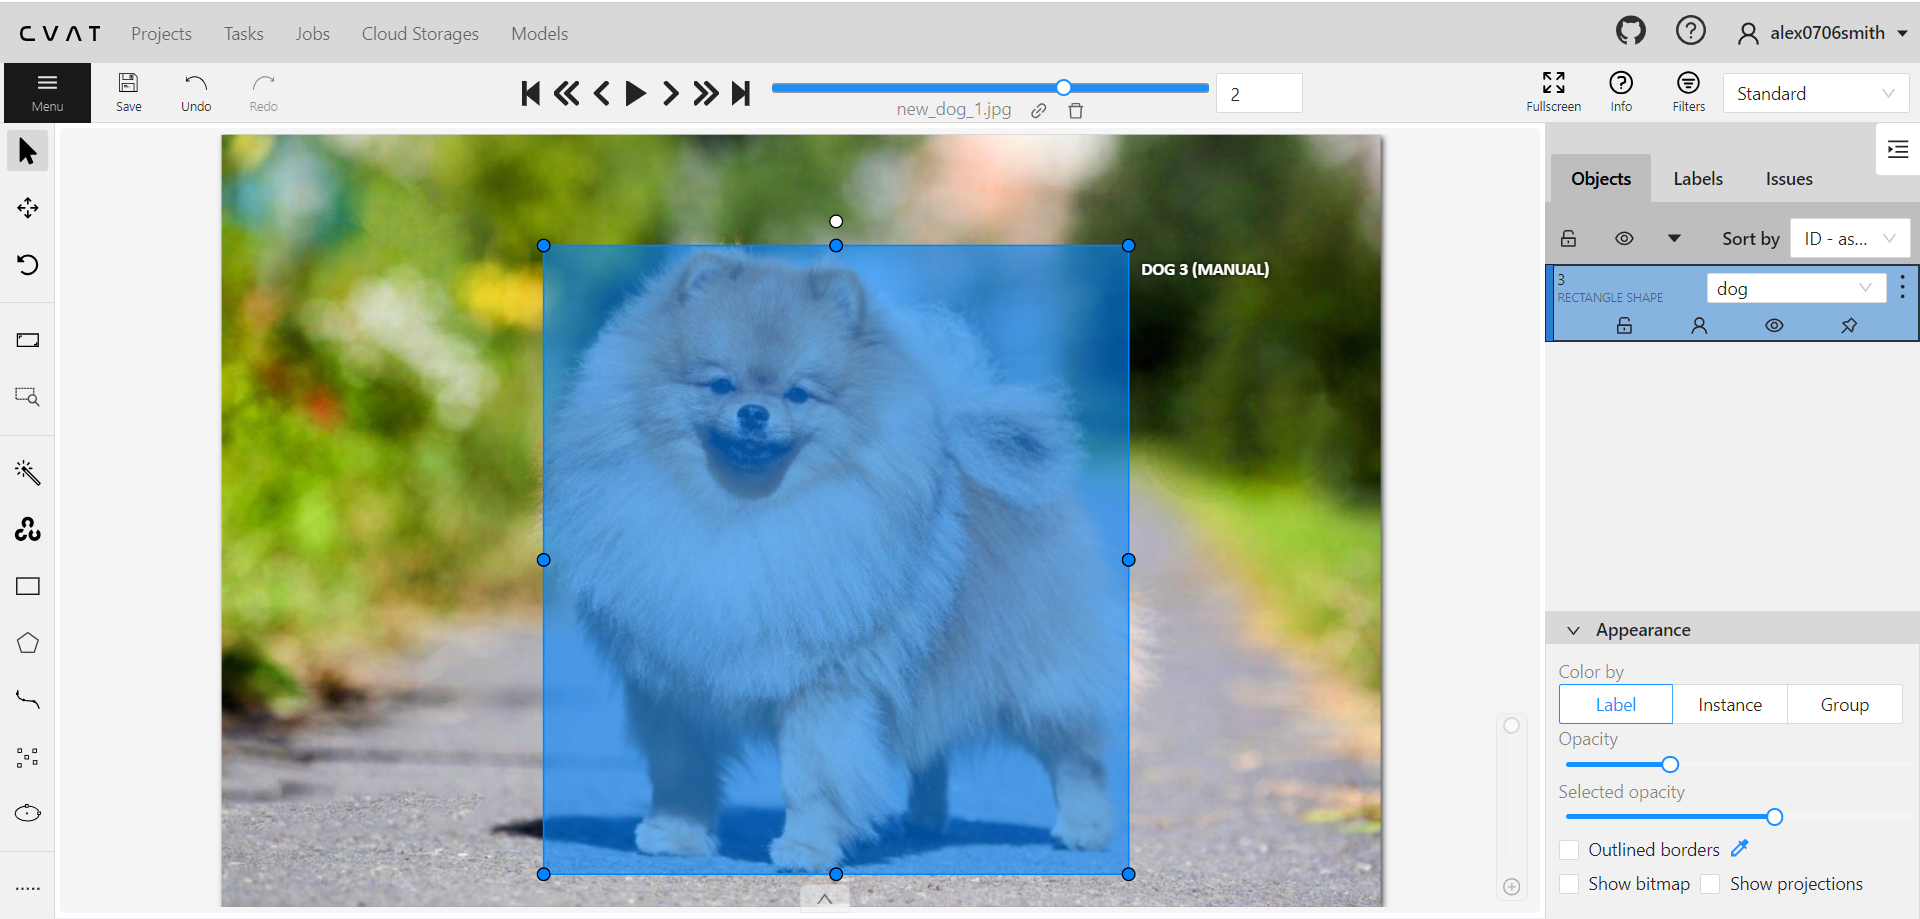

In [144]:
root_new = "/content/new_cats_dogs"
dset_new = AnimalDetectionDataset(root_new, transforms=ResNet50_Weights.IMAGENET1K_V2.transforms(), target_transform=le)
dset_new[0]

(tensor([[[-1.3254, -1.2835, -1.2445,  ..., -1.0928, -1.0928, -1.1075],
          [-1.3107, -1.2698, -1.2274,  ..., -1.1318, -1.1212, -1.1371],
          [-1.2959, -1.2788, -1.2445,  ..., -1.1879, -1.1893, -1.2156],
          ...,
          [ 0.7883,  0.7918,  0.7745,  ...,  1.1711,  1.4139,  1.4243],
          [ 0.8688,  0.7199,  0.7709,  ...,  1.0895,  1.1579,  1.2465],
          [ 0.8523,  0.7532,  0.4709,  ...,  1.2479,  1.0917,  1.3982]],
 
         [[-1.2256, -1.1827, -1.1429,  ..., -1.0052, -1.0052, -1.0203],
          [-1.2105, -1.1687, -1.1253,  ..., -1.0451, -1.0343, -1.0505],
          [-1.1954, -1.1779, -1.1429,  ..., -1.0674, -1.0689, -1.0958],
          ...,
          [ 0.9353,  0.9390,  0.9792,  ...,  1.3967,  1.6450,  1.6556],
          [ 1.0176,  0.8655,  0.9755,  ...,  1.3133,  1.3832,  1.4738],
          [ 1.0008,  0.8994,  0.6688,  ...,  1.4752,  1.3155,  1.6289]],
 
         [[-0.9979, -0.9552, -0.8807,  ..., -0.8482, -0.8482, -0.8633],
          [-0.9829, -0.9413,

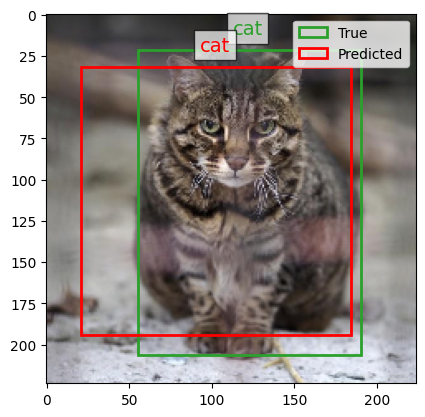

In [145]:
# cat
model.eval()
cl_out, reg_out = model(dset_new[0][0].unsqueeze(0).to(device))

show_image_with_bounding_box(dset_new[0], pred=(reg_out.squeeze(0).detach().cpu(), cl_out.argmax().item()), target_transform=le, scaled=True, mean=mean, std=std)

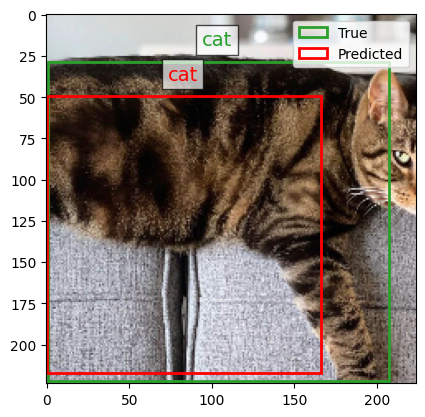

In [146]:
# cat
model.eval()
cl_out, reg_out = model(dset_new[1][0].unsqueeze(0).to(device))

show_image_with_bounding_box(dset_new[1], pred=(reg_out.squeeze(0).detach().cpu(), cl_out.argmax().item()), target_transform=le, scaled=True, mean=mean, std=std)

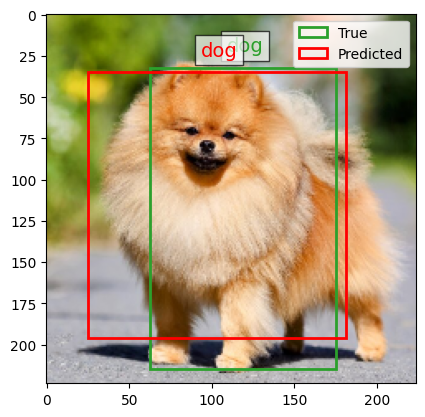

In [147]:
# dog
model.eval()
cl_out, reg_out = model(dset_new[2][0].unsqueeze(0).to(device))

show_image_with_bounding_box(dset_new[2], pred=(reg_out.squeeze(0).detach().cpu(), cl_out.argmax().item()), target_transform=le, scaled=True, mean=mean, std=std)

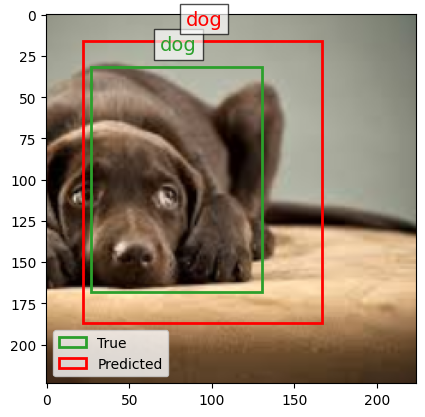

In [148]:
# dog
model.eval()
cl_out, reg_out = model(dset_new[3][0].unsqueeze(0).to(device))

show_image_with_bounding_box(dset_new[3], pred=(reg_out.squeeze(0).detach().cpu(), cl_out.argmax().item()), target_transform=le, scaled=True, mean=mean, std=std)

<p class="task" id="7"></p>

7*\. Повторите решение предыдущей задачи, используя модель `fasterrcnn_resnet50_fpn`. Замените слой для предсказания bounding box на `FastRCNNPredictor` с нужным количеством классов.

- [ ] Проверено на семинаре

In [212]:
# device = 'cpu'

In [18]:
model7 = models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1) #, weights_backbone=ResNet50_Weights.IMAGENET1K_V2)
for param in model7.parameters():
  param.requires_grad = False
in_features = model7.roi_heads.box_predictor.cls_score.in_features
model7.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)
model7.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [20]:
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder


cl_criterion = nn.CrossEntropyLoss()
reg_criterion = nn.MSELoss()
optimizer = optim.Adam(model7.parameters(), lr=0.001)
le = LabelEncoder().fit(['cat', 'dog'])

root = "/content/drive/MyDrive/Учеба/DL/06_cv/Asirra: cat vs dogs"
dataset = AnimalDetectionDataset(root, transforms=ResNet50_Weights.IMAGENET1K_V2.transforms(), target_transform=le)

batch_size = 32
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_epochs = 5
for epoch in range(num_epochs):
  model7.train()
  for imgs, coors, labels in test_loader:
    imgs, coors, labels = list(image.to(device) for image in imgs), torch.stack(list(coors.values())).T.float(), labels
    targets = [{'boxes': coor.unsqueeze(0).to(device), 'labels': labels[i].long().to(device)} for i, coor in enumerate(coors)]

    optimizer.zero_grad()
    loss_dict = model7(imgs, targets)
    total_loss = sum(loss for loss in loss_dict.values())
    total_loss.backward()
    optimizer.step()

  print(f"-----epoch {epoch+1}-----")
  print(f"train loss: {total_loss.item()}")


-----epoch 1-----
train loss: 2.371584892272949
-----epoch 2-----
train loss: 2.371340751647949
-----epoch 3-----
train loss: 2.361217498779297
-----epoch 4-----
train loss: 2.3700382709503174
-----epoch 5-----
train loss: 2.3715603351593018


In [22]:
loss_dict

{'loss_classifier': tensor(0.0010, device='cuda:0', grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>),
 'loss_objectness': tensor(1.7758, device='cuda:0'),
 'loss_rpn_box_reg': tensor(0.5946, device='cuda:0')}

In [21]:
model7.eval()
model7(list(image.to(device) for image in imgs))

[{'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward0>)},
 {'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward0>)},
 {'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward0>)},
 {'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward0>)},
 {'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cu

## Обратная связь
- [ ] Хочу получить обратную связь по решению